In [1]:
from lmfit import minimize, Parameters

import pandas as pd
import tellurium as te
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

import aesara.tensor as at
import aesara
floatX = aesara.config.floatX

import os 
os.chdir('..')
from emll.aesara_utils import LeastSquaresSolve
os.chdir('notebooks')

WARNING (aesara.configdefaults): g++ not available, if using conda: `conda install m2w64-toolchain`
WARNING (aesara.configdefaults): g++ not detected!  Aesara will be unable to compile C-implementations and will default to Python. Performance may be severely degraded. To remove this warning, set Aesara flags cxx to an empty string.
WARNING (aesara.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


## Setting up experiment for one regulator

In [2]:
# import the data 
df = pd.read_csv('../data/Simplified_Teusink_reg1_1.01.csv')

In [3]:
r = te.loada('../models/Simplified_Teusink_reg1.ant')
r.steadyState()
N=r.getFullStoichiometryMatrix()

In [4]:
enzymes = ['e_' + i for i in r.getReactionIds()]
internal = r.getFloatingSpeciesIds()
external = r.getBoundarySpeciesIds()
fluxes = ['v_' + i for i in r.getReactionIds()]

v_star = df[fluxes].loc[0]

In [5]:
ex = r.getScaledElasticityMatrix()

a = r.getBoundarySpeciesIds()
b = r.getReactionIds()
c=[]
for i in b: 
    for ii in a: 
        c.append(r.getUnscaledParameterElasticity(i, ii) * r[ii]/r[i])
ey = np.array(c).reshape((len(b),len(a)))

In [6]:
en = df[enzymes].loc[1:len(r.getReactionIds())]/df[enzymes].loc[0]
xn = df[internal].loc[1:len(r.getReactionIds())]/df[internal].loc[0]
vn = df[fluxes].loc[1:len(r.getReactionIds())]/df[fluxes].loc[0]
yn = df[external].iloc[-(len(vn)):]/df[external].loc[0]


## Using lmfit to predict elasticity values w/o ey values

In [7]:
def cb(params, iter, resid, *args, **kws):
    print(iter, (resid**2).sum().sum())

def residual(params, xn, yn, v_star, df, *args, **kws):
    
    ex_params = [params[ii] for ii in [i for i in params]]
    ex = np.asarray(ex_params).reshape((16,11))
    
    a = (en.values*v_star.values)
    bb = np.ones((16,16))
    cc = ex@(np.log(xn)).T

    model = a.T*(bb + cc)

    return (df[fluxes].loc[1:len(r.getReactionIds())].values-model.T).values

params = Parameters()

for i in range(16*(11)):
    params.add('Ex'+str(i), value=0, min=-10, max=10)

out = minimize(residual, params, args=(xn, yn, v_star, df))#, iter_cb=cb)

print(out.chisqr)
# out.params

9.674707863284879e-10


In [8]:
predicted_Exs = np.array([out.params[i].value for i in out.params]).reshape((16,11))
difference = predicted_Exs-ex
difference[np.abs(difference) < 1e-3] = 0
difference

 [[ 0.00228247, -0.00314129,           0,           0,           0,           0,           0,           0,           0,          0,           0],
  [          0,           0,           0,           0,           0,           0,           0,           0,           0,          0,           0],
  [ 0.00113284,           0,           0,           0,           0,           0,           0,           0,           0,          0,           0],
  [  0.0011396,           0,           0,           0,           0,           0,           0,           0,           0,          0,           0],
  [          0,           0, -0.00127745,           0,           0,           0,           0,           0,           0, 0.00191173,           0],
  [          0,           0,           0, -0.00201173,  0.00224084,           0,           0,           0,           0,          0,           0],
  [          0,           0,           0,           0, -0.00132549,  0.00172971,           0,           0,           0,     

### testing out prediction error across different perturbation strengths

In [17]:
def residual(params, xn, yn, v_star, df, *args, **kws):
    
    ex_params = [params[ii] for ii in [i for i in params]]
    ex = np.asarray(ex_params).reshape((16,11))
    
    a = (en.values*v_star.values)
    bb = np.ones((16,16))
    cc = ex@(np.log(xn)).T

    model = a.T*(bb + cc)

    return (df[fluxes].loc[1:len(r.getReactionIds())].values-model.T).values


In [38]:
# import the data 
def calculate_ratios(pt_lvl):
    df = pd.read_csv(f'../data/Simplified_Teusink_reg1_{pt_lvl}.csv')

    r = te.loada('../models/Simplified_Teusink_reg1.ant')
    r.steadyState()
    
    internal = r.getFloatingSpeciesIds()
    fluxes = ['v_' + i for i in r.getReactionIds()]

    v_star = df[fluxes].loc[0]
    xn = df[internal].loc[1:len(r.getReactionIds())]/df[internal].loc[0]

    params = Parameters()

    for i in range(16*(11)):
        params.add('Ex'+str(i), value=0, min=-10, max=10)

    out = minimize(residual, params, args=(xn, yn, v_star, df))#, iter_cb=cb)

    return out.chisqr, np.array([out.params[i].value for i in out.params]).reshape((16,11))

In [39]:
pt_levels = [0.1, 0.2, 0.3, 0.4, 0.5, 1.01, 1.5, 3, 5, 7, 10]

predicted_Exs = []
chisqrs = []

for lvl in pt_levels: 
    a, b = calculate_ratios(lvl)
    chisqrs.append(a)
    predicted_Exs.append(b)

In [25]:
ex

               GLCi,      G6P,      F6P,      F16P,      TRIO,       BPG,     P3G,       P2G,       PEP,       PYR,       ACE
vGLK   [[   1.59035, -1.57923,        0,         0,         0,         0,       0,         0,         0,         0,         0],
vPGI    [         0,  1.85002, -1.47259,         0,         0,         0,       0,         0,         0,         0,         0],
vGLYCO  [         0,        1,        0,         0,         0,         0,       0,         0,         0,         0,         0],
vTreha  [         0,        1,        0,         0,         0,         0,       0,         0,         0,         0,         0],
vPFK    [         0,        0,  1.01332, -0.213181,         0,         0,       0,         0,         0, -0.680728,         0],
vALD    [         0,        0,        0,   1.22064, -0.782826,         0,       0,         0,         0,         0,         0],
vGAPDH  [         0,        0,        0,         0,    1.0535, -0.646927,       0,         0,         0,  

In [41]:
len(predicted_Exs)

11

In [45]:
Ex_labels = [
        j + ', ' + k         # result
        for j in r.getFloatingSpeciesIds()   # for loop 
        for k in r.getReactionIds() # for loop
                     # condition   
       ]

In [63]:
all_Exs = pd.concat([pd.DataFrame(i.flatten(), index=Ex_labels) for i in predicted_Exs])
all_Exs['pt_lvl'] = np.repeat(pt_levels, 176)
all_Exs.reset_index(inplace=True)
all_Exs.columns = ['Ex_label', 'value','pt_lvl']

all_Exs['reaction'] = [i.split(', ')[0] for i in all_Exs['Ex_label']]
all_Exs['metabolite'] = [i.split(', ')[1] for i in all_Exs['Ex_label']]

all_Exs

,Ex_label,value,pt_lvl,reaction,metabolite
0,"GLCi, vGLK",-0.032361,0.1,GLCi,vGLK
1,"GLCi, vPGI",0.293121,0.1,GLCi,vPGI
2,"GLCi, vGLYCO",0.004675,0.1,GLCi,vGLYCO
3,"GLCi, vTreha",-0.004991,0.1,GLCi,vTreha
4,"GLCi, vPFK",0.051623,0.1,GLCi,vPFK
...,...,...,...,...,...
1931,"ACE, vPDC",-0.144884,10.0,ACE,vPDC
1932,"ACE, vSUC",-0.258578,10.0,ACE,vSUC
1933,"ACE, vGLT",-0.059497,10.0,ACE,vGLT
1934,"ACE, vADH",-0.219264,10.0,ACE,vADH


In [132]:
# q = all_Exs.pivot(index=['reaction','metabolite'], columns=['pt_lvl'] ,values='value', sort=False)
q = pd.pivot_table(all_Exs, values='value', index=['reaction','metabolite'], columns=['pt_lvl'], sort=False)
q.head()

pt_lvl                  0.10      0.20      0.30      0.40      0.50   \
reaction metabolite                                                     
GLCi     vGLK       -0.032361 -0.047564 -0.047889 -0.035467 -0.015188   
         vPGI        0.293121  0.348903  0.367260  0.359112  0.335141   
         vGLYCO      0.004675  0.007136  0.007812  0.006549  0.004317   
         vTreha     -0.004991 -0.004536 -0.000475  0.004098  0.007990   
         vPFK        0.051623  0.051999  0.047564  0.043242  0.039518   

pt_lvl                  1.01      1.50      3.00      5.00      7.00   \
reaction metabolite                                                     
GLCi     vGLK        1.592629  0.358881  0.588952  0.711292  0.762034   
         vPGI       -1.582369 -0.169128 -0.494431 -0.663558 -0.731946   
         vGLYCO      0.000023 -0.017315 -0.031940 -0.039652 -0.043478   
         vTreha     -0.000045  0.021602  0.024298  0.023696  0.022708   
         vPFK       -0.000058  0.015826  0.004109 -0.000729 -0.002269   

pt_lvl                  10.00  
reaction metabolite            
GLCi     vGLK        0.795409  
         vPGI       -0.774707  
         vGLYCO     -0.046695  
         vTreha      0.021473  
         vPFK       -0.002905

In [136]:
Ex_differences = q.sub(r.getScaledElasticityMatrix().transpose().flatten(), axis=0)
Ex_differences.head()

pt_lvl                  0.10      0.20      0.30      0.40      0.50   \
reaction metabolite                                                     
GLCi     vGLK       -1.622708 -1.637911 -1.638236 -1.625814 -1.605535   
         vPGI        0.293121  0.348903  0.367260  0.359112  0.335141   
         vGLYCO      0.004675  0.007136  0.007812  0.006549  0.004317   
         vTreha     -0.004991 -0.004536 -0.000475  0.004098  0.007990   
         vPFK        0.051623  0.051999  0.047564  0.043242  0.039518   

pt_lvl                  1.01      1.50      3.00      5.00      7.00   \
reaction metabolite                                                     
GLCi     vGLK        0.002282 -1.231466 -1.001395 -0.879055 -0.828313   
         vPGI       -1.582369 -0.169128 -0.494431 -0.663558 -0.731946   
         vGLYCO      0.000023 -0.017315 -0.031940 -0.039652 -0.043478   
         vTreha     -0.000045  0.021602  0.024298  0.023696  0.022708   
         vPFK       -0.000058  0.015826  0.004109 -0.000729 -0.002269   

pt_lvl                  10.00  
reaction metabolite            
GLCi     vGLK       -0.794938  
         vPGI       -0.774707  
         vGLYCO     -0.046695  
         vTreha      0.021473  
         vPFK       -0.002905

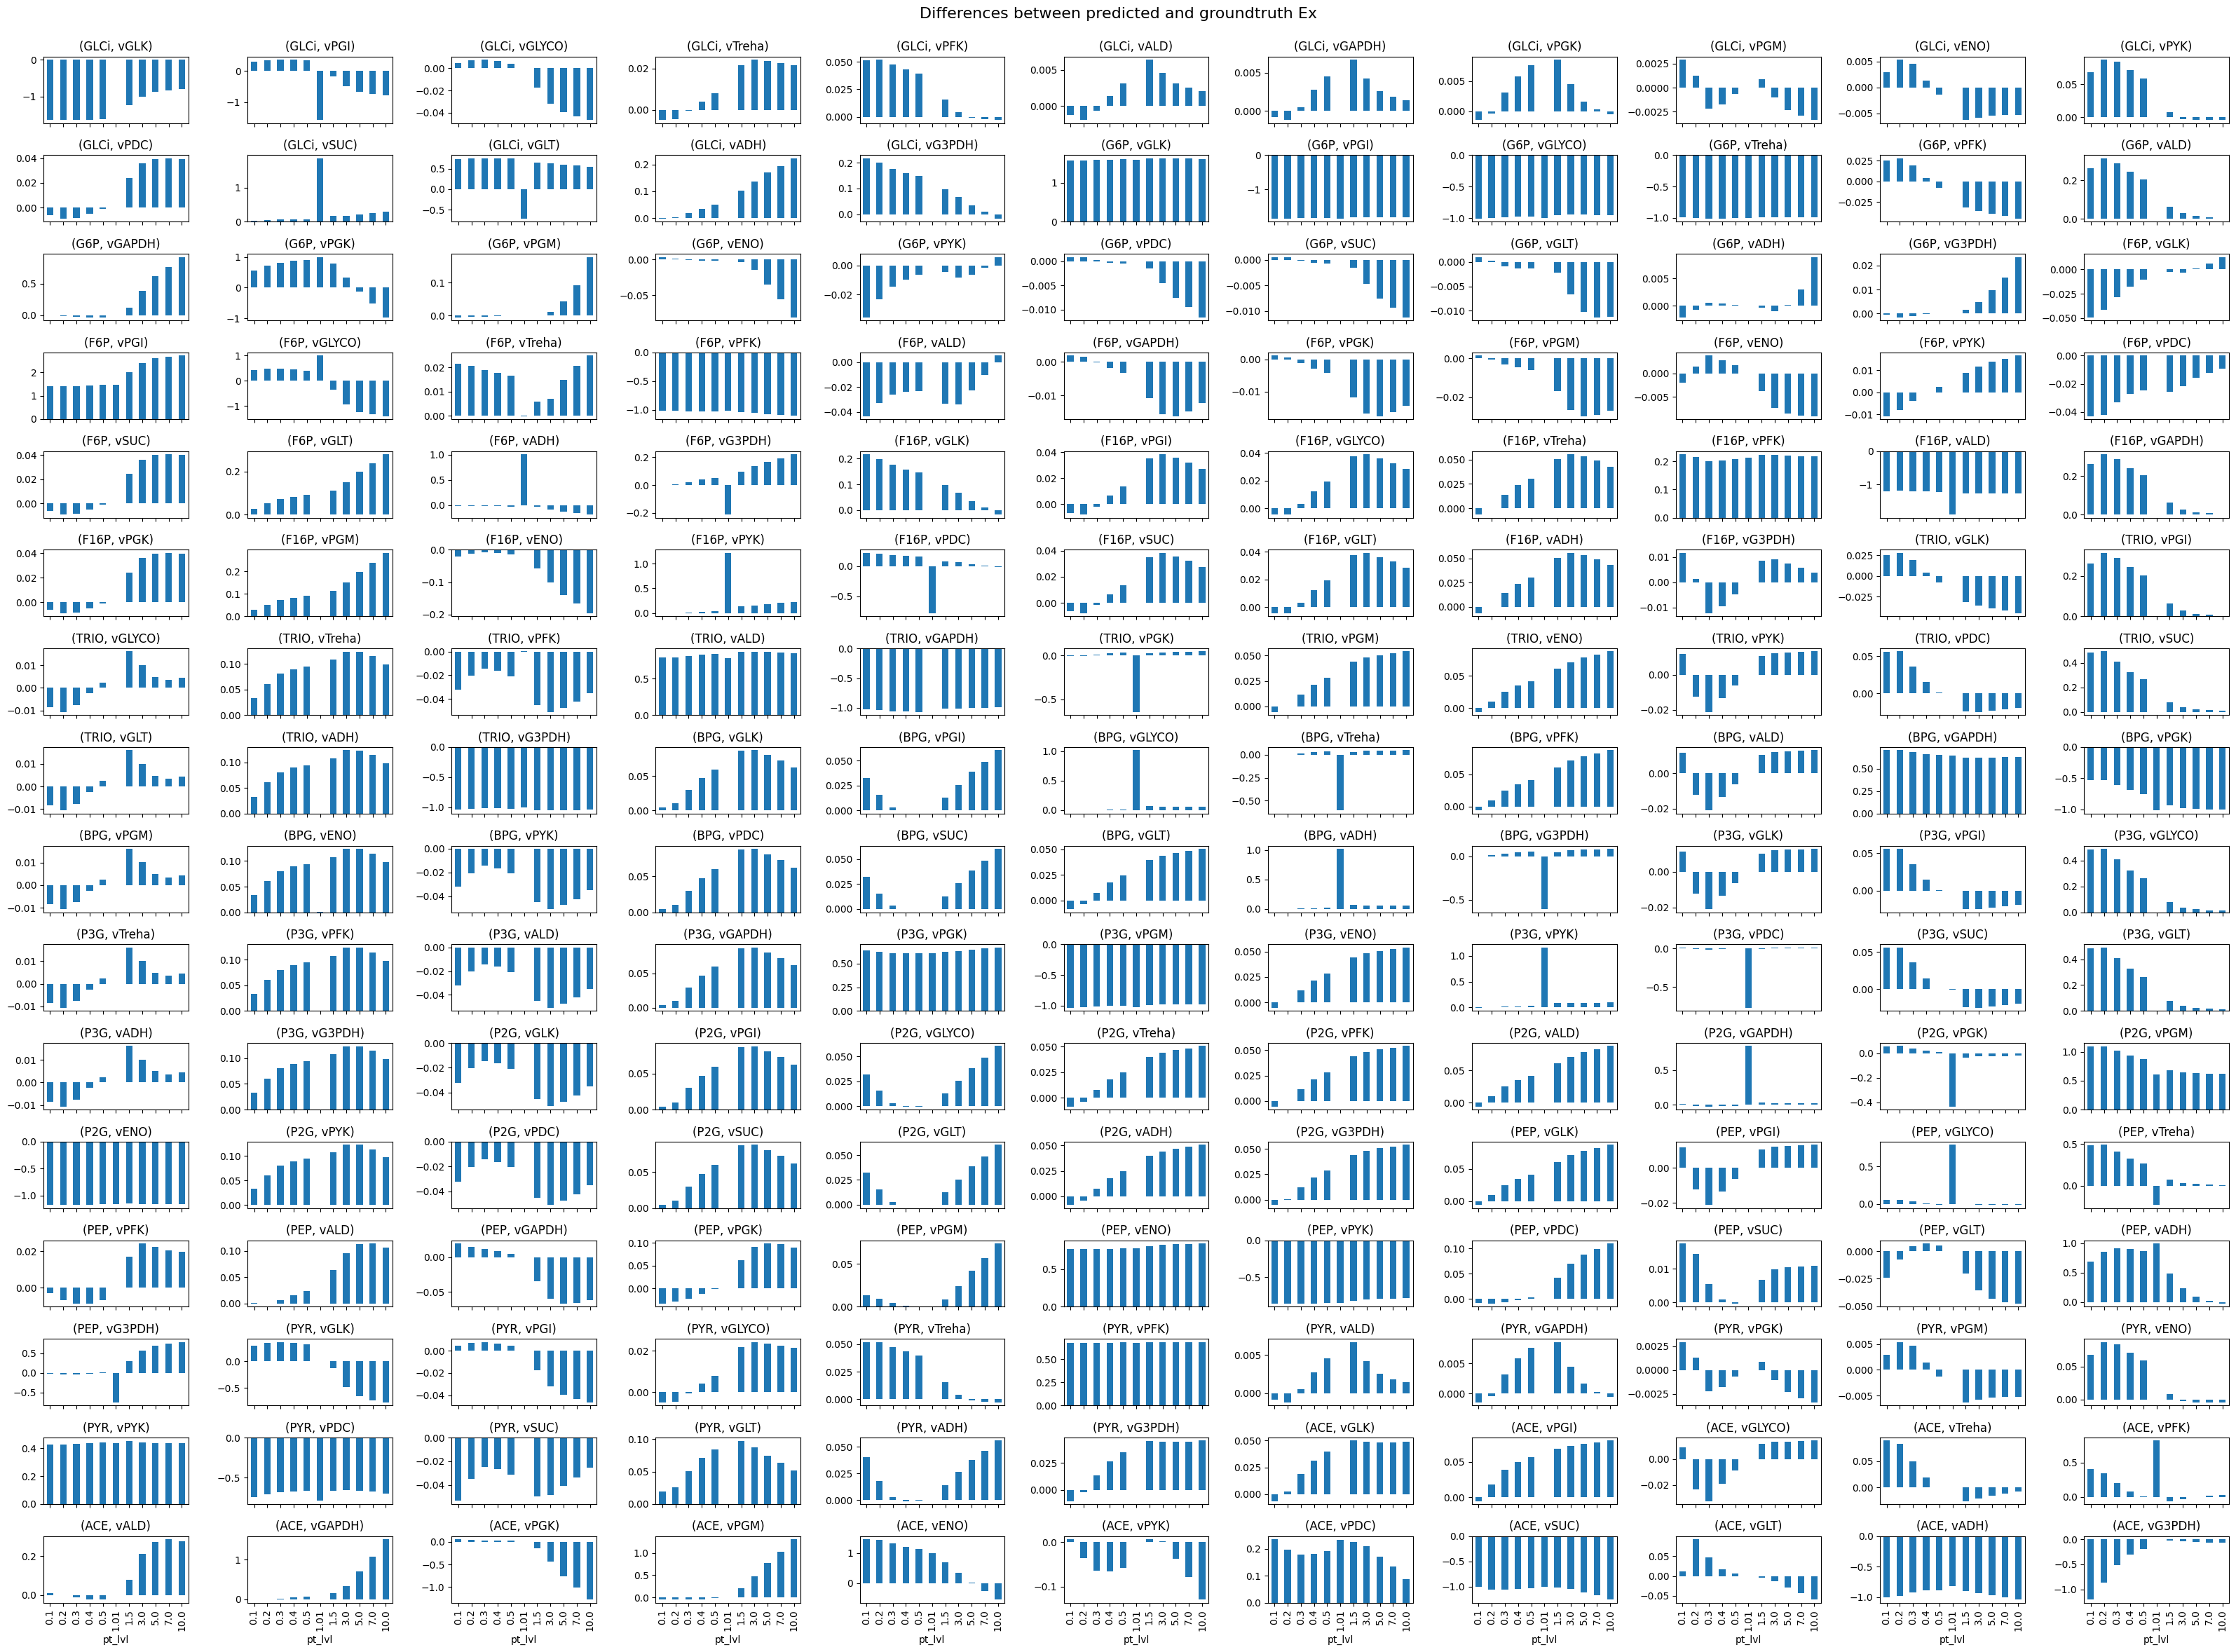

In [153]:
pt_labels = [str(i) for i in q.columns]

fig, ax = plt.subplots(16,11, sharex=True, figsize=(32,24))

for i in range(16):
    for ii in range(11):
        Ex_differences.iloc[i * 11 + ii].plot(ax=ax[i,ii], kind='bar', subplots=True, title=', '.join(list(Ex_differences.index[i * 11 + ii])))
fig.suptitle('Differences between predicted and groundtruth Ex\n\n', fontsize=16)
fig.tight_layout()


In [33]:
subplot

predicted_Exs-ex

array([[ 7.62033809e-01, -7.31945909e-01, -4.34779534e-02,
         2.27079131e-02, -2.26949776e-03,  2.52097950e-03,
         1.85650587e-03,  3.11721503e-04, -2.93980001e-03,
        -5.29331249e-03, -4.43927965e-03],
       [ 4.00118382e-02,  2.52377067e-01, -1.78149042e-01,
         1.94582569e-01,  1.07911307e-02,  3.21832558e-02,
         3.27931289e-02,  4.92431795e-02,  5.70344819e-03,
        -4.15202194e-02,  6.46684011e-03],
       [ 7.63888642e-01, -5.07289196e-01,  9.13825667e-02,
        -5.59965163e-02, -1.58702854e-03, -9.51966929e-03,
        -9.35297442e-03, -1.13705067e-02,  2.96023218e-03,
         1.50144981e-02,  5.90891758e-03],
       [ 1.20368219e+00, -1.34448546e+00,  2.07241101e-02,
        -7.72340835e-02, -1.04856015e-02, -1.48674388e-02,
        -1.64049683e-02, -2.91422896e-02, -8.89612866e-03,
         1.53593259e-02, -1.22423615e-02],
       [ 4.06242756e-02,  2.36318326e-01, -1.58907003e-01,
         1.93420233e-01,  1.06079962e-02,  3.20527769e-02,
  

## Setting up experiment for two regulators

In [10]:
# import the data 
df = pd.read_csv('../data/Simplified_Teusink_reg2_1.01.csv')

In [11]:
r = te.loada('../models/Simplified_Teusink_reg2.ant')
r.steadyState()
N=r.getFullStoichiometryMatrix()

In [12]:
ex = r.getScaledElasticityMatrix()

a = r.getBoundarySpeciesIds()
b = r.getReactionIds()
c=[]
for i in b: 
    for ii in a: 
        c.append(r.getUnscaledParameterElasticity(i, ii) * r[ii]/r[i])
ey = np.array(c).reshape((len(b),len(a)))

In [13]:
params = Parameters()

for i in range(16*(11)):
    params.add('Ex'+str(i), value=0, min=-10, max=10)

out = minimize(residual, params, args=(xn, yn, v_star, df))#, iter_cb=cb)

print(out.chisqr)
# out.params

13.863434987548382


In [14]:
predicted_Exs = np.array([out.params[i].value for i in out.params]).reshape((16,11))
difference = predicted_Exs-ex
difference[np.abs(difference) < 1e-3] = 0
difference

 [[ -0.0793764,   0.0294628,  0.050399, -0.0172844,           0, -0.00401787, -0.0253895, -0.00457577,  0.00287165,  0.0128209,  0.0316793],
  [  -0.230492,     1.15723,  -1.14341,  -0.122484,  -0.0147421,  -0.0300841,   0.486245,  -0.0357161,   0.0175729,   0.085955,   0.187136],
  [  0.0691044,   0.0167431, -0.104518,   0.031959, -0.00524951,  0.00701147,  0.0522274,  0.00740747,  -0.0062227, -0.0252445, -0.0688865],
  [   0.114325,   -0.141874, -0.103022,  0.0286261, -0.00980416,  0.00579484,  0.0508828,  0.00558369, -0.00647225, -0.0241406, -0.0728598],
  [   -0.23022,   0.0194978,  0.546376,  -0.170319,   -0.014293,   -0.030096,  -0.169501,  -0.0356056,   0.0175761,  -0.106331,   0.187145],
  [  -0.230399,   0.0196621,  0.331727,   0.128019,   -0.292527,  -0.0302573,  -0.169595,  -0.0356897,   0.0175633,  0.0858619,     0.1873],
  [  -0.208551,   0.0113589,  0.312684,  -0.109448,      0.2427,   -0.249121,  -0.162411,   -0.036338,   0.0162819,  0.0737581,   0.156211],
  [  -0.20852